In [1]:
import xgboost as xgb
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

import sys 
sys.path.insert(0, "/Users/elenasmith/Documents/personal/water_git/")
from src.data import data
from src.visualization import visualize

In [2]:
interim_data_path  ="/Users/elenasmith/Documents/personal/water_git/data/interim/"
model_path  ="/Users/elenasmith/Documents/personal/water_git/models/"

In [3]:
deliv_train = pd.read_csv("{}4_unit_correction_model___train.csv".format(interim_data_path))
deliv_test_X= pd.read_csv("{}4_unit_correction_model___test.csv".format(interim_data_path))

In [5]:
xgb_train_X = deliv_train.drop("original_units_incorrect",axis=1).as_matrix()

In [6]:
gbm = xgb.XGBClassifier()

In [7]:
model = gbm.load_model("{}model_2.model".format(model_path)) 

### Explore variable effects with SHAP

In [8]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(xgb_train_X)


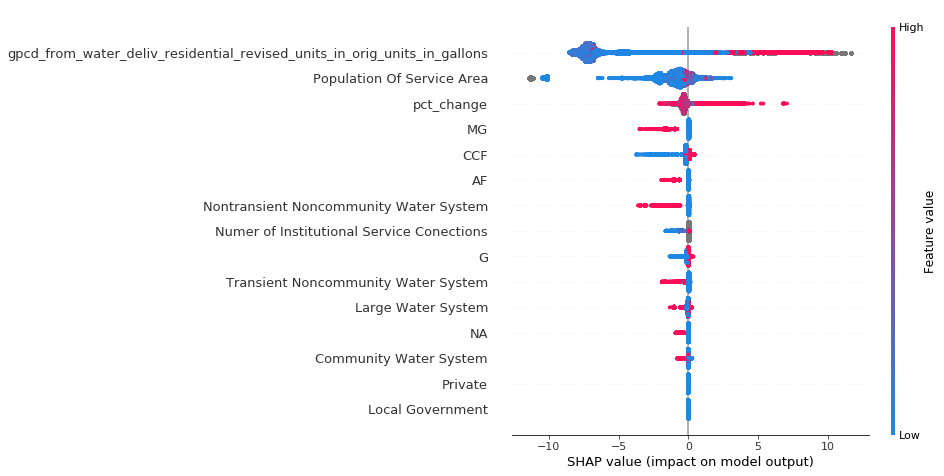

In [9]:
#summarize the effects of all the features
shap.summary_plot(shap_values, xgb_train_X,feature_names=deliv_test_X.drop("original_units_incorrect",axis=1).columns.values)

### Export data

In [10]:
shapDF = data.generate_shap_df(shap_values,xgb_train_X)

In [11]:
shapDF['feature'].value_counts()

12    60955
10    60955
9     60955
6     60955
1     60249
0     58978
14    34466
Name: feature, dtype: int64

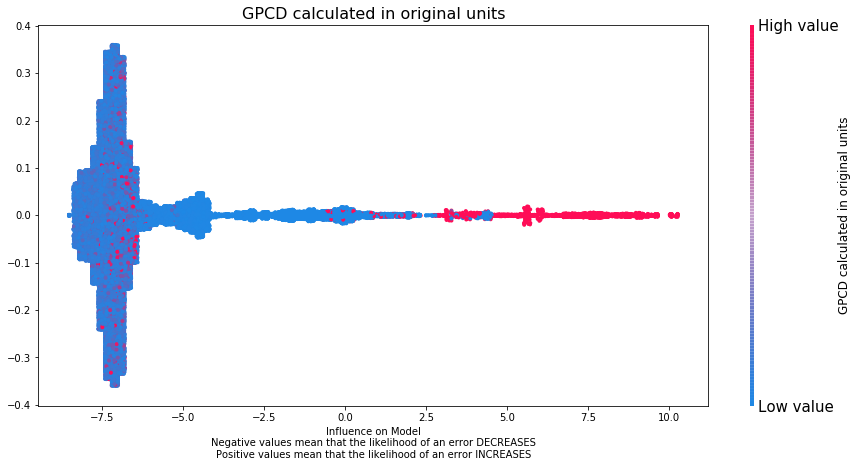

In [12]:
x =  visualize.single_shap_plot(0,shapDF,"GPCD calculated in original units")
plt.title("GPCD calculated in original units")
plt.show()

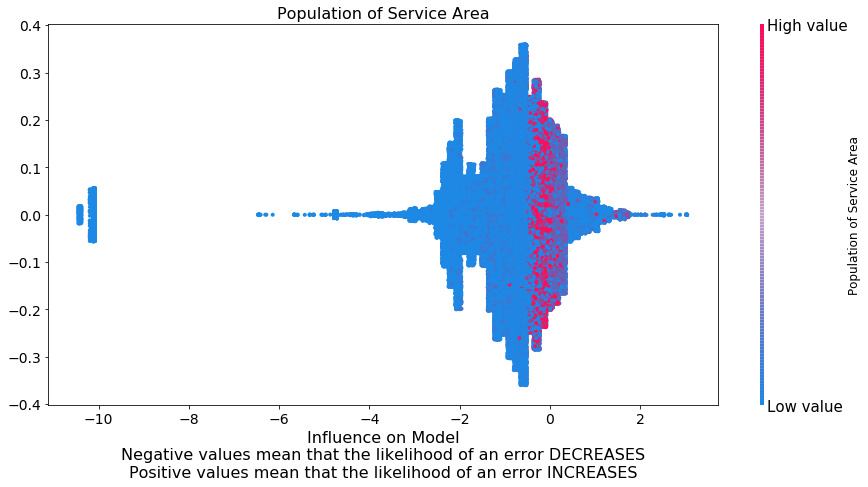

In [13]:
x =  visualize.single_shap_plot(1,shapDF,"Population of Service Area")
plt.title("Population of Service Area")
plt.show()

### Explore interactions

In [14]:
shap_interaction_values = shap.TreeExplainer(gbm).shap_interaction_values(xgb_train_X)

### Feature importance plot

In [15]:
friendlyNames = {"gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons":"GPCD, from self-reported units and values",
                'Population Of Service Area': 'Population Of Service Area',
                'Community Water System': 'System Classification: Community',
                'Large Water System': 'System Classification: Large',
                'Local Government': 'System Classification: Local Goverment',
                'NA': 'System Classification: N/A',
                'Nontransient Noncommunity Water System': 'System Classification: Nontransient Noncommunity',
                'Private': 'System Classification: Private',
                'Transient Noncommunity Water System': 'System Classification: Transient Noncommunity',
                'AF': 'Original Units: AF',
                 'CCF': 'Original Units: CCF',
                 'G': 'Original Units: G',
                 'MG': 'Original Units: MG',
                 'Numer of Institutional Service Conections': '# Institutional Service Connections',
                 'pct_change': "YoY % Change in Water System's GPCD"
                }
friendlyNamesDF = pd.DataFrame.from_dict(friendlyNames,orient="index").reset_index()
friendlyNamesDF.columns=["predictors","pred_friendly_name"]
predictors = list(deliv_train.columns.values)[:-1]

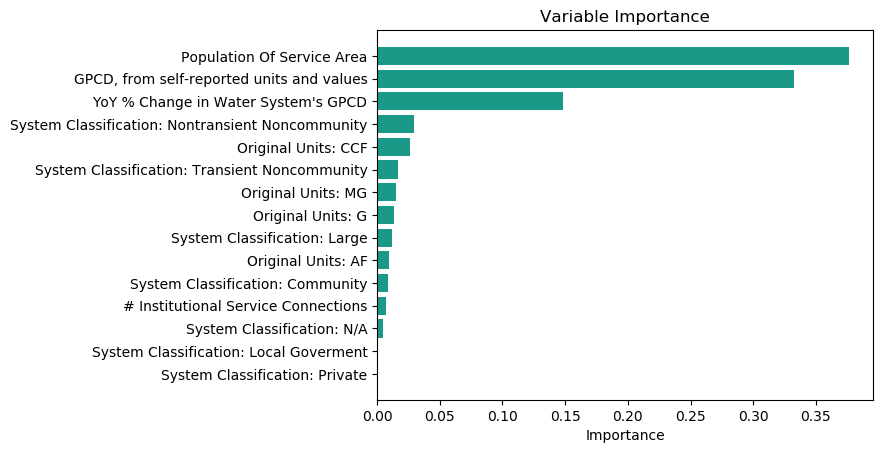

In [16]:
plt.rcdefaults()
fig, ax = plt.subplots()
varImp = pd.DataFrame({"predictors": predictors,
                      "imp": gbm.feature_importances_})
varImp = varImp.sort_values('imp',ascending=False)
varImp["y_pos"] = np.arange(len(predictors))
varImp = varImp.merge(friendlyNamesDF,on="predictors")
ax.barh(varImp['y_pos'],varImp['imp'], align='center',
        color='#1a9988', ecolor='black')

ax.set_yticks(varImp["y_pos"])
ax.set_yticklabels(varImp['pred_friendly_name'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Variable Importance')

plt.show()